In [1]:
import os
import pandas as pd
from torchvision.io import read_image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset,DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#! pip install einops

# 1. Build ViT model using pytorch

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size = 16, emb_size = 768, img_size = 224):
        self.patch_size = patch_size
        super().__init__()
        self.pro = nn.Sequential(
            nn.Conv2d(3, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.token = nn.Parameter(torch.randn(1,1, emb_size))
        
        # Positional embeddings
        self.pos = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x):
        b = x.shape[0]
        x = self.pro(x)
        tokens = repeat(self.token, '() n e -> b n e', b=b)
    
        x = torch.cat([tokens, x], dim=1)
        
        x += self.pos
        return x
    
class MHA(nn.Module):
    def __init__(self, d_model, num_heads=8):
        super(MHA, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.qkv = nn.Linear(d_model, d_model*3)
        self.projection = nn.Linear(d_model, d_model)
    def forward(self, x, mask=None):
        qkv = self.qkv(x).chunk(3, dim=-1)
        queries, keys, values = [t.reshape(t.shape[0], -1, self.num_heads, self.d_model // self.num_heads).transpose(1, 2) for t in qkv]
        E = torch.matmul(queries, keys.transpose(-2, -1))
        
        if mask:
            fv = torch.finfo(torch.float32).min
            E.mask_fill(~mask, fv)
            
        
        attn = F.softmax(E, dim=-1)/self.d_model**0.5
        out = torch.einsum('bhal, bhlv -> bhav ', attn, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
    
class FFB(nn.Sequential):
    def __init__(self, emb_size, expansion= 4):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(expansion * emb_size, emb_size),
        )
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,emb_size= 768,forward_expansion = 4,** kwargs):
        super().__init__(
            Residual(nn.Sequential(nn.LayerNorm(emb_size),MHA(emb_size, **kwargs),nn.Dropout(0.2))),
            Residual(nn.Sequential(
                nn.LayerNorm(emb_size),
                FFB(emb_size, expansion=forward_expansion),
                nn.Dropout(0.2)
            )
            ))
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class ClassificationHead(nn.Module):
    def __init__(self, emb_size=768, n_classes=4):
        super().__init__()
        self.reduce = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(emb_size, emb_size),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(emb_size, emb_size)
        )
        self.norm = nn.LayerNorm(emb_size)
        self.fc = nn.Linear(emb_size, n_classes)

    def forward(self, x):
        x = self.reduce(x)
        x = x.mean(dim=1)
        x = self.norm(x)
        x = self.fc(x)
        return x
        
class ViT(nn.Sequential):
    def __init__(self,patch_size = 16,emb_size= 768,img_size= 224,depth= 8,n_classes = 4,**kwargs):
        super().__init__(
            PatchEmbedding(patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

* Ref:   
https://www.youtube.com/watch?v=HZ4j_U3FC94&t=4s&ab_channel=ShusenWang  
https://github.com/FrancescoSaverioZuppichini/ViT

# 2. Download the [cow teat datasets](https://github.com/YoushanZhang/SCTL) and train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [4]:
train_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Train'
test_dir = r'D:\application for the usa\YU\6. Deep learning\HW 6 NN for cow teats classification\Test'

In [5]:
batch_size = 2
transform = transforms.Compose([transforms.Resize((275, 275)),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [6]:
test_transform = transforms.Compose([transforms.Resize((275,275)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [7]:
class TestSet(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_labels = os.listdir(img_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = Image.open(img_path) 
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
train_data = ImageFolder(train_dir,transform = transform)


 # Random split
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size
train_set, valid_set = random_split(train_data, [train_set_size, valid_set_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

test_dataset = TestSet(img_dir = test_dir, transform = test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [9]:
model = ViT().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [10]:
from datetime import datetime
start_time = datetime.now()

all_trainloss= []
all_valloss= []
all_acc = []
all_train_acc=[]
steps = 20

for epoch in range(steps):
    train_loss = 0
    train_correct=0
    for batch in train_loader:
        x, y = batch

        x, y = x.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)      
        loss.backward()
        optimizer.step() 
        train_loss+=loss.item()   
        predict = pred.argmax(dim=1, keepdim=True)
        train_correct += predict.eq(y.view_as(predict)).sum().item()
        
    train_acc = 100. * train_correct / len(train_loader.dataset)        
    model.eval()
    val_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)
        val_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_loss/=len(train_loader)
    val_loss /= len(valid_loader)
    accuracy = 100. * correct / len(valid_loader.dataset)
    
    #scheduler.step(val_loss)
    
    if accuracy >= 60 or (epoch+1)%100 == 0:
        PATH = f'Vit_{epoch+1}.pth'
        torch.save(model.state_dict(), PATH)        
    
    all_trainloss.append(train_loss)
    all_train_acc.append(train_acc)    
    all_valloss.append(val_loss)
    all_acc.append(accuracy)
    
    
    print(f'Epoch:{epoch+1} | Train Loss: {train_loss}| train_acc:{train_acc} | Validation Loss:{val_loss} | val_acc:{accuracy}')
    print()
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch:1 | Train Loss: 1.0400133165976275| train_acc:56.25680087051143 | Validation Loss:0.9425189819024957 | val_acc:59.130434782608695

Epoch:2 | Train Loss: 0.9844639234244823| train_acc:57.562568008705114 | Validation Loss:0.9296859111474908 | val_acc:57.391304347826086

Epoch:3 | Train Loss: 0.974345791955357| train_acc:57.018498367791075 | Validation Loss:0.9214377307373545 | val_acc:60.869565217391305

Epoch:4 | Train Loss: 0.9647849333675012| train_acc:57.99782372143634 | Validation Loss:0.9092619514983633 | val_acc:63.04347826086956

Epoch:5 | Train Loss: 0.9663013966835063| train_acc:58.54189336235038 | Validation Loss:0.9080799654774044 | val_acc:62.17391304347826

Epoch:6 | Train Loss: 0.9589415117450383| train_acc:57.12731229597389 | Validation Loss:0.9021669053513071 | val_acc:64.78260869565217

Epoch:7 | Train Loss: 0.9549827663794808| train_acc:57.78019586507073 | Validation Loss:0.9065804090188897 | val_acc:62.17391304347826

Epoch:8 | Train Loss: 0.9463991280807101| tr

In [11]:
df = pd.DataFrame(zip(all_trainloss,all_train_acc,all_valloss,all_acc))

# 3. Evaluate your model using the developed software

In [12]:
index = (df[df.iloc[:,3]>=60].index.values)+1
for i in index:

    PATH = f'Vit_{i}.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    
    CNN_pred=[]
    test_y=[]
    with torch.no_grad():
        for data in test_loader:
            x, y = data
            #print(y)
            x = x.to('cuda')
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            CNN_pred+=predicted.tolist()
            test_y+= list(y)
    res =  pd.DataFrame(list(zip(test_y, CNN_pred)))
    res.to_csv(f'Vit_{i}_.csv',index=False,header=False)

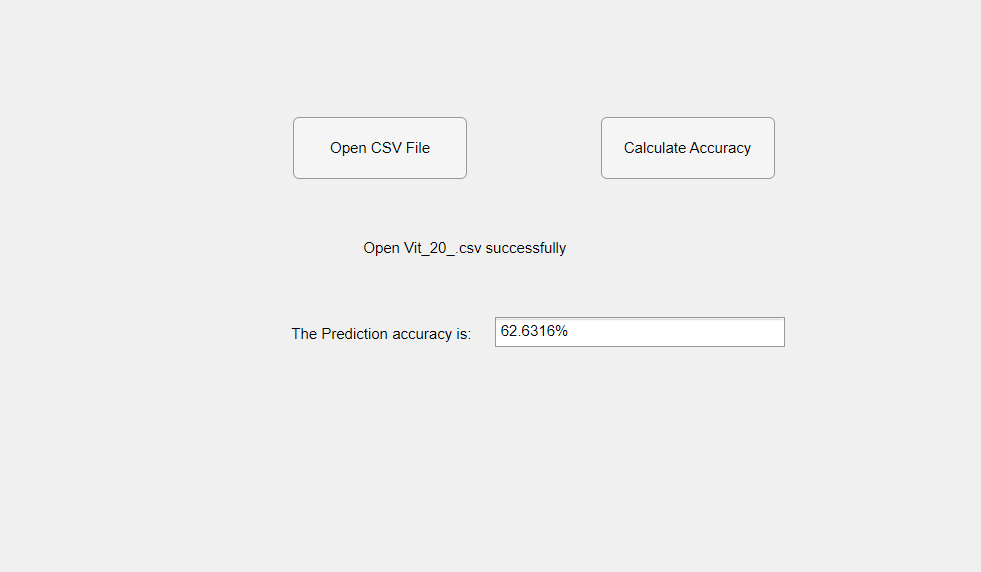